In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

## Main Code for simulating the trajectories using the Euler Scheme

#### Local volatilities

In [2]:
# Local Volatilities sigma
import math
def sigma1(t,x, k, alpha, beta):
    y = k*(1+alpha*np.sqrt(t+0.1)/T+beta*t*np.exp(-x))
    return y

def sigma2(t,x, k, alpha, beta):
    y = k*(2+alpha*np.cos(4*math.pi*t/T)+beta*t/(1+x**2))
    return y

#### Simulating r, S^0, S_tilda and S

In [3]:
T=4
N=1000
n=1000

r0= 0.03
a = 0.1
b =  0.02
gamma = 0.2
rho = 0.6
S_tilda0 = 50
k = 0.3
alpha = 1.2
beta = 1.5


r = r0*np.ones((n+1,N))
S0 = np.ones((n+1,N))
S_tilda_1= S_tilda0*np.ones((n+1,N)) # S_tilda using local volatility 1 
S_1 = np.ones((n+1,N))

S_tilda_2= S_tilda0*np.ones((n+1,N)) # S_tilda using local volatility 2
S_2 = np.ones((n+1,N))

for j in range(N): 
    for i in range(1,n+1):
        t = T/n*(i-1)
        dB = np.sqrt(T/n)*np.random.randn()  # shared between r and C
        dW = np.sqrt(T/n)*np.random.randn()  # independent from dB

        r[i,j] = r[i-1,j]+a*(b-r[i-1,j])*T/n+ gamma*np.sqrt(np.abs(r[i-1,j]))*dB 
        S0[i,j] = S0[i-1,j]+ S0[i-1,j]*r[i-1,j]*T/n

        sigma1_val = sigma1(t, S_tilda_1[i - 1, j], k, alpha, beta)
        
        S_tilda_1[i,j] = S_tilda_1[i-1,j]+sigma1_val*S_tilda_1[i-1,j]*(rho*dB +np.sqrt(1-rho**2)*dW) #using sigma_1
        S_1[i,j] = S_tilda_1[i,j]*S0[i,j]

        sigma2_val = sigma2(t, S_tilda_2[i - 1, j], k, alpha, beta)   

        S_tilda_2[i,j] = S_tilda_2[i-1,j]+sigma2_val*S_tilda_2[i-1,j]*(rho*dB +np.sqrt(1-rho**2)*dW) #using sigma_2
        S_2[i,j] = S_tilda_2[i,j]*S0[i,j]  

In [4]:
def plot_traject(x_data, y_data, title):
    plt.figure(figsize=(8,6))
    plt.plot(x_data, y_data)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

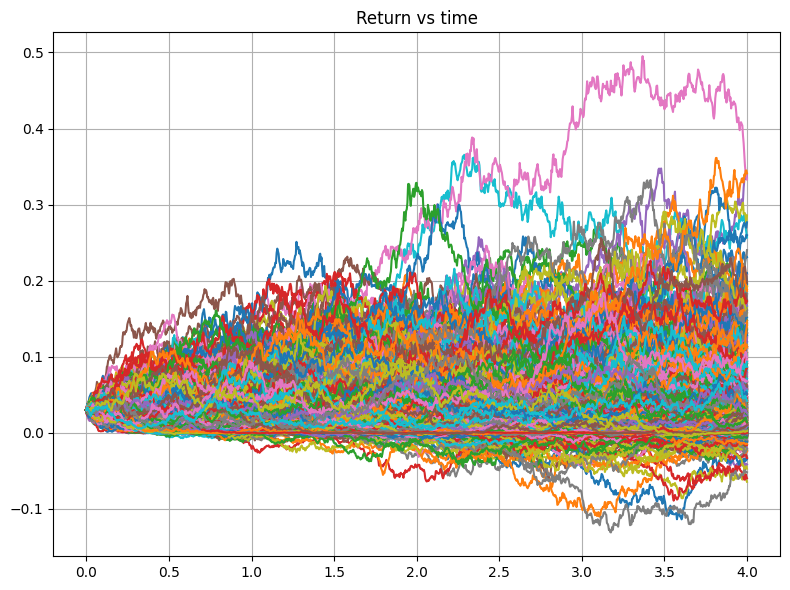

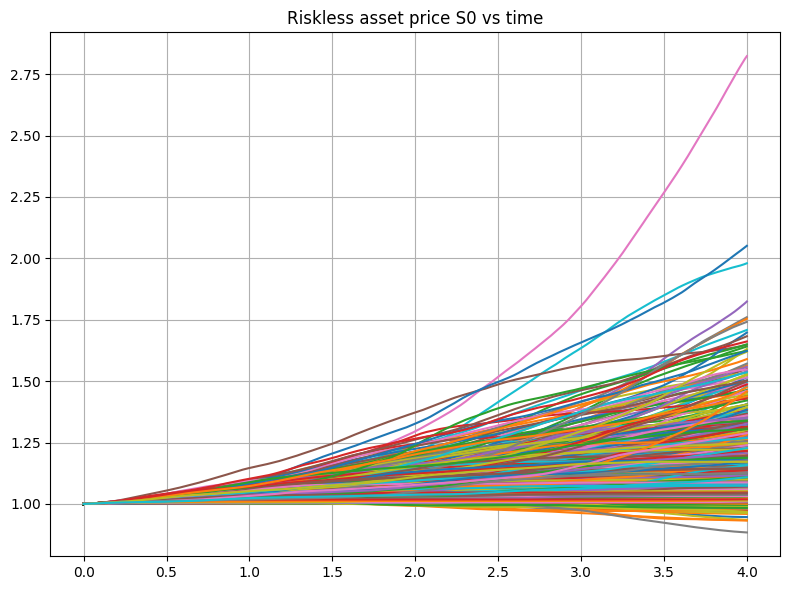

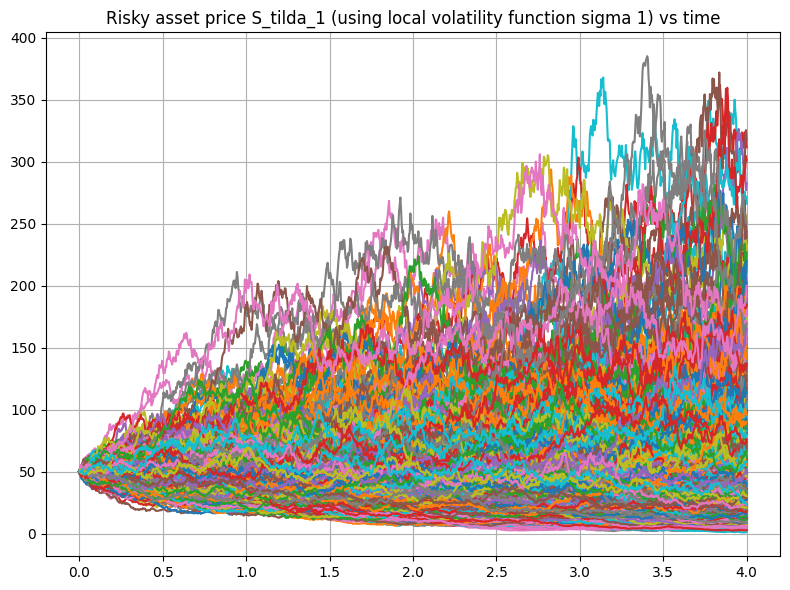

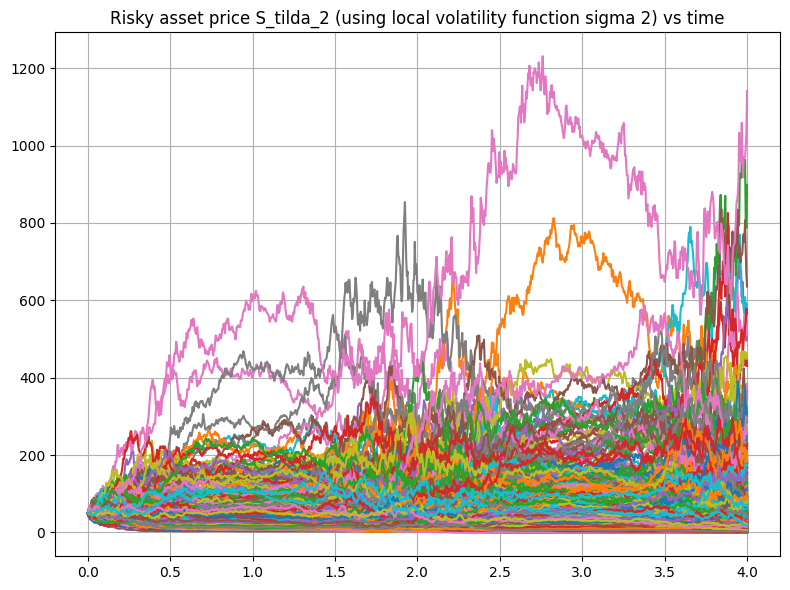

In [5]:
dates = np.linspace(0,T,n+1)

plot_traject(dates, r, "Return vs time")
plot_traject(dates, S0, "Riskless asset price S0 vs time")
plot_traject(dates, S_tilda_1, "Risky asset price S_tilda_1 (using local volatility function sigma 1) vs time")
plot_traject(dates, S_tilda_2, "Risky asset price S_tilda_2 (using local volatility function sigma 2) vs time")

#### Payoff ksi_1

In [6]:
# ksi1 = max(K1-ST, ST-K2, 0); 0<K1<K2; S0 in between (K1, K2)
DP1_1 = []
DP1_2 = []
K1 = 30
K2 = 60
for j in range(N):
    dp1_1 = max(0, K1-S_1[n,j], S_1[n,j]-K2)/S0[n,j]
    dp1_2 = max (0, K1-S_2[n,j], S_2[n,j]-K2)/S0[n,j]
    DP1_1.append(dp1_1) 
    DP1_2.append(dp1_2)  

POE1_1 = np.mean(DP1_1)
POE1_2 = np.mean(DP1_2)

In [7]:
print(f"The replicating prices for payoff 1 are: {POE1_1} using local volatility 1, and {POE1_2} using local volatility 2")

The replicating prices for payoff 1 are: 20.47775005396866 using local volatility 1, and 31.16121822956306 using local volatility 2


#### Payoff ksi_2

In [8]:
# ksi2 = np.abs(1/T*integ from 0 to T of Sudu-K3); K3 = S0
DP2_1 = []
DP2_2 = []
K1 = 30
K2 = 60
for j in range (N) :   
    integ_1 = np.mean(S_1[: ,j]) #np.trapz(S[:, j], dx=dt)
    integ_2 = np.mean(S_2[: ,j])
    
    K3_1 = S_1[0,j] # it is equal to S_tilda[0,j]
    K3_2 = S_2[0,j]
    dp2_1 =np.abs(integ_1-K3_1)/S0[n,j]
    dp2_2 =np.abs(integ_2-K3_2)/S0[n,j]

    DP2_1.append(dp2_1)
    DP2_2.append(dp2_2)

POE2_1 = np.mean(DP2_1)
POE2_2 = np.mean(DP2_2)

In [9]:
print(f"The replicating prices for payoff 2 are: {POE2_1} using local volatility 1, and {POE2_2} using local volatility 2")

The replicating prices for payoff 2 are: 45.653528118715386 using local volatility 1, and 44.440166019197754 using local volatility 2


We have also introduced a different way of computing the integral using the trapezoidal method

In [10]:
DP2_1_trap = []
DP2_2_trap = []
K1 = 30
K2 = 60
for j in range (N) :   
    integ_1 = np.trapz(S_1[:, j], dx=T/n)/T
    integ_2 = np.trapz(S_2[:, j], dx=T/n)/T
    K3_1 = S_1[0,j] # it is equal to S_tilda[0,j]
    K3_2 = S_2[0,j]
    dp2_1 =np.abs(integ_1-K3_1)/S0[n,j]
    dp2_2 =np.abs(integ_2-K3_2)/S0[n,j]
    DP2_1_trap.append(dp2_1)
    DP2_2_trap.append(dp2_2)

POE2_1_trap = np.mean(DP2_1_trap)
POE2_2_trap = np.mean(DP2_2_trap)

C:\Users\monci\AppData\Local\Temp\ipykernel_13560\676423424.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_1 = np.trapz(S_1[:, j], dx=T/n)/T
C:\Users\monci\AppData\Local\Temp\ipykernel_13560\676423424.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_2 = np.trapz(S_2[:, j], dx=T/n)/T


In [11]:
print(f"The replicating prices for payoff 2 when using trapezoidal rule are: {POE2_1_trap} using local volatility 1, and {POE2_2_trap} using local volatility 2")

The replicating prices for payoff 2 when using trapezoidal rule are: 45.67521839792616 using local volatility 1, and 44.46165498034798 using local volatility 2


## Sensitivity Analysis


In [ ]:

def run_trajectory(T=4, N=1000, n=1000, r0= 0.03, a = 0.1, b = 0.02,
                    gamma = 0.2, rho = 0.6, S_tilda0 = 50, k = 0.3,
                    alpha = 1.2, beta = 1.5, K1=30, K2=70):
    
    r = r0*np.ones((n+1,N))
    S0 = np.ones((n+1,N))
    S_tilda_1= S_tilda0*np.ones((n+1,N)) # S_tilda using local volatility 1 
    S_1 = np.ones((n+1,N))

    S_tilda_2= S_tilda0*np.ones((n+1,N)) # S_tilda using local volatility 2
    S_2 = np.ones((n+1,N))

    for j in range(N): 
        for i in range(1,n+1):
            t = T/n*(i-1)
            dB = np.sqrt(T/n)*np.random.randn()  # shared between r and C
            dW = np.sqrt(T/n)*np.random.randn()  # independent from dB

            r[i,j] = r[i-1,j]+a*(b-r[i-1,j])*T/n+ gamma*np.sqrt(np.abs(r[i-1,j]))*dB 
            S0[i,j] = S0[i-1,j]+ S0[i-1,j]*r[i-1,j]*T/n

            sigma1_val = sigma1(t, S_tilda_1[i - 1, j], k, alpha, beta)
        
            S_tilda_1[i,j] = S_tilda_1[i-1,j]+sigma1_val*S_tilda_1[i-1,j]*(rho*dB +np.sqrt(1-rho**2)*dW) #using sigma_1
            S_1[i,j] = S_tilda_1[i,j]*S0[i,j]

            sigma2_val = sigma2(t, S_tilda_2[i - 1, j], k, alpha, beta)   

            S_tilda_2[i,j] = S_tilda_2[i-1,j]+sigma2_val*S_tilda_2[i-1,j]*(rho*dB +np.sqrt(1-rho**2)*dW) #using sigma_2
            S_2[i,j] = S_tilda_2[i,j]*S0[i,j]  

    DP1_1 = []
    DP1_2 = []
    DP2_1 = []
    DP2_2 = []
    
    for j in range(N):
        dp1_1 = max(0, max(K1 - S_1[n, j], S_1[n, j] - K2)) / S0[n, j]
        dp1_2 = max(0, max(K1 - S_2[n, j], S_2[n, j] - K2)) / S0[n, j]
        DP1_1.append(dp1_1)
        DP1_2.append(dp1_2)
        
        integ_1 = np.mean(S_1[:, j])
        integ_2 = np.mean(S_2[:, j])
        K3_1 = S_1[0, j]
        K3_2 = S_2[0, j]
        dp2_1 = np.abs(integ_1 - K3_1) / S0[n, j]
        dp2_2 = np.abs(integ_2 - K3_2) / S0[n, j]
        DP2_1.append(dp2_1)
        DP2_2.append(dp2_2)
    
    # Average the payoffs over paths
    POE1_1 = np.mean(DP1_1)
    POE1_2 = np.mean(DP1_2)
    POE2_1 = np.mean(DP2_1)
    POE2_2 = np.mean(DP2_2)
    
    return POE1_1, POE1_2, POE2_1, POE2_2

### 1. Sensitivity for 𝑎

𝑎- is known as Mean-Reversion Speed and it control how quickly the interest rate reverts to its long-term mean 𝑏. A large 𝑎 means the interest rate doesn’t stay too far from 𝑏 for long. It reflects the strength of monetary policy correction mechanisms.

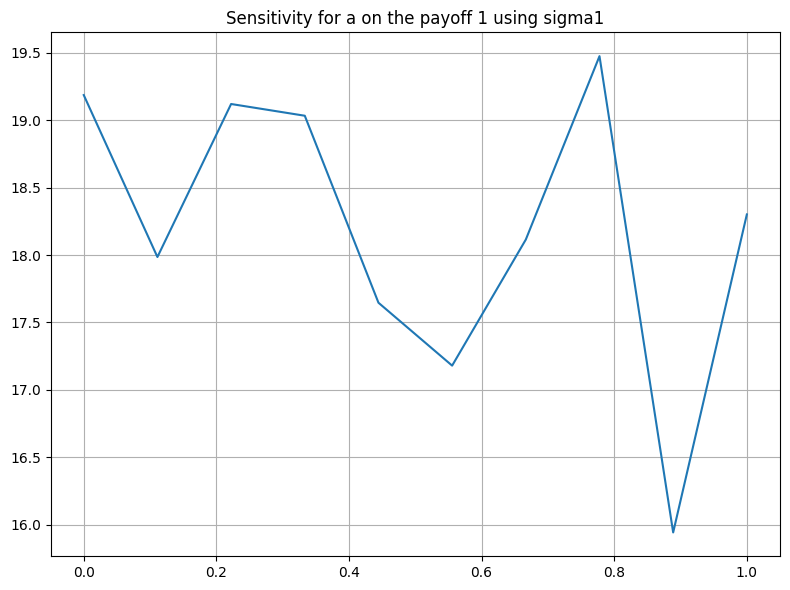

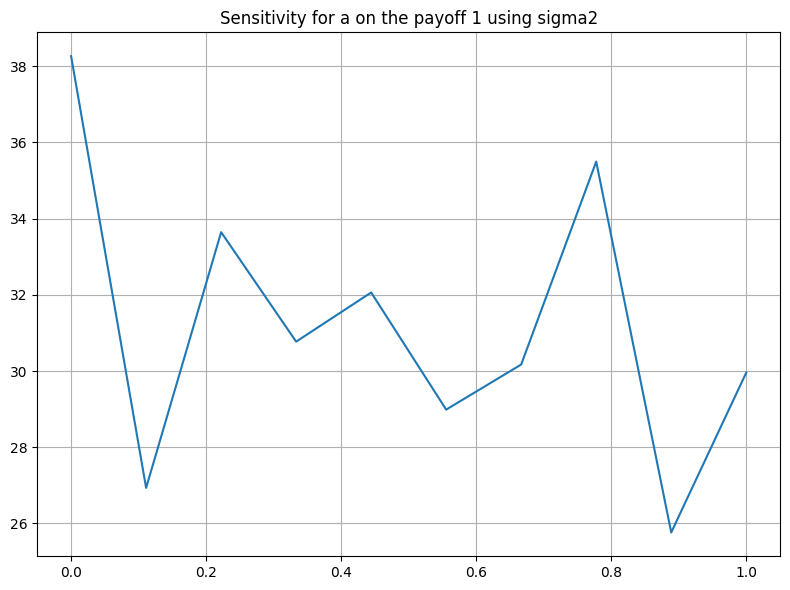

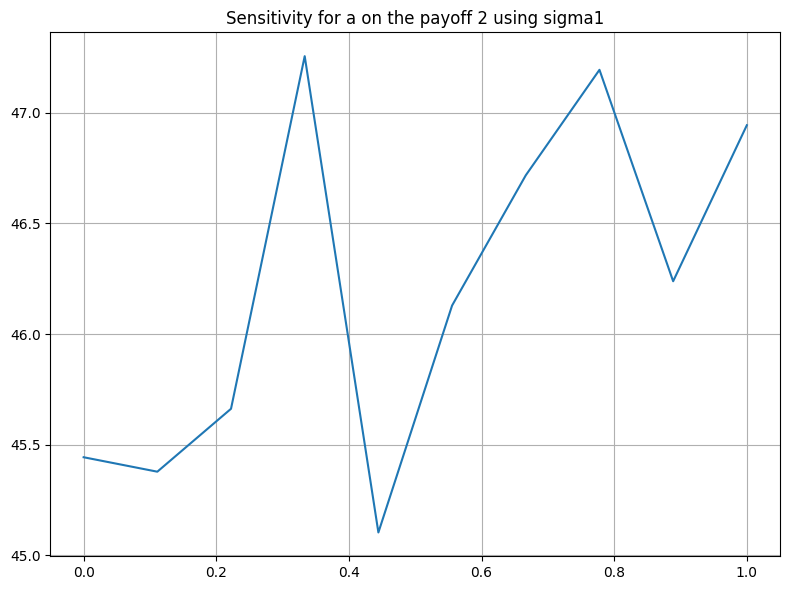

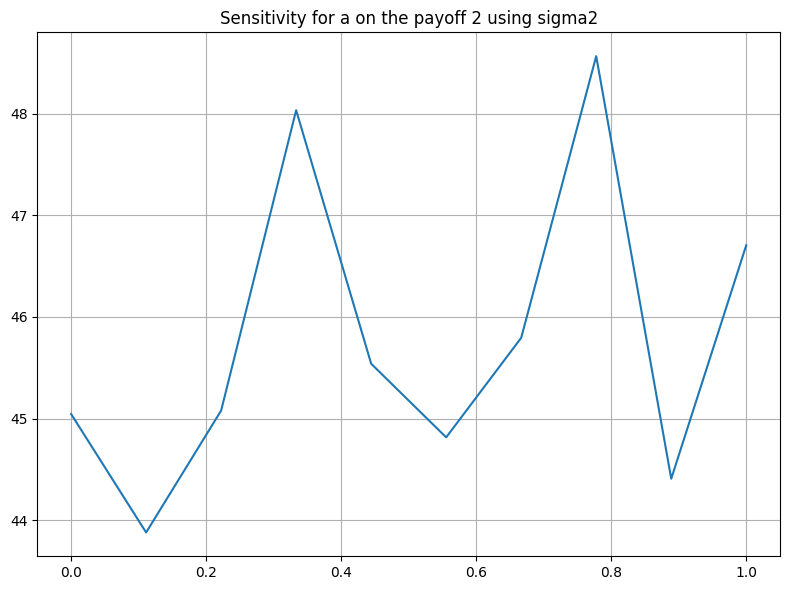

In [20]:
a_list = np.linspace(0, 1, 10)

POE1_1_a = [] 
POE1_2_a = [] 
POE2_1_a = [] 
POE2_2_a = []

for a  in a_list:
    result = run_trajectory(T=4, N=1000, n=1000, r0= 0.03, a = a, b = 0.02,
                    gamma = 0.2, rho = 0.6, S_tilda0 = 50, k = 0.3,
                    alpha = 1.2, beta = 1.5, K1=30, K2=70)  
    POE1_1_a.append(result[0])
    POE1_2_a.append(result[1])
    POE2_1_a.append(result[2])
    POE2_2_a.append(result[3])

plot_traject(a_list, POE1_1_a, "Sensitivity for a on the payoff 1 using sigma1")
plot_traject(a_list, POE1_2_a, "Sensitivity for a on the payoff 1 using sigma2")
plot_traject(a_list, POE2_1_a, "Sensitivity for a on the payoff 2 using sigma1")
plot_traject(a_list, POE2_2_a, "Sensitivity for a on the payoff 2 using sigma2")

### 2. Sensitivity for 𝑏

𝑏-Long-Run Mean Rate for the short-term interest rates. Interpreted as the central bank's neutral interest rate or the long-term average level of interest rates. On average, higher interest rates → affects bond prices, risk-free discounting.


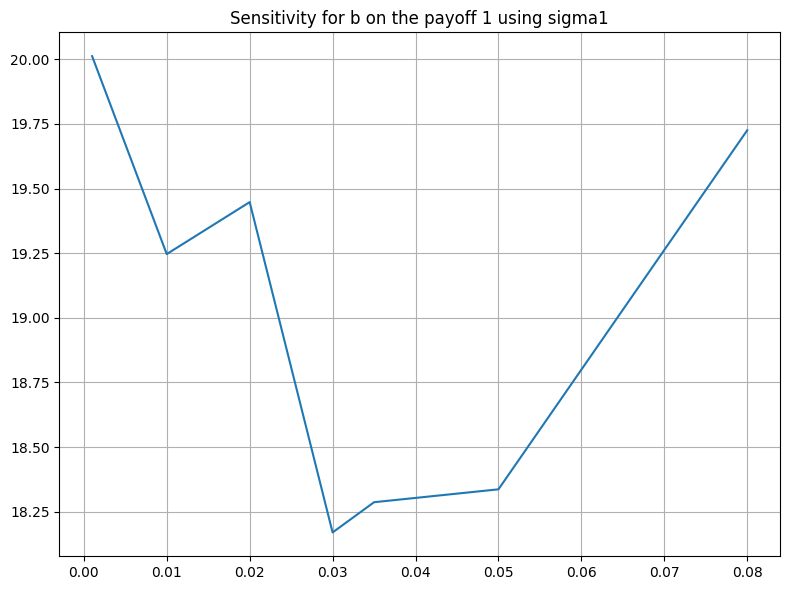

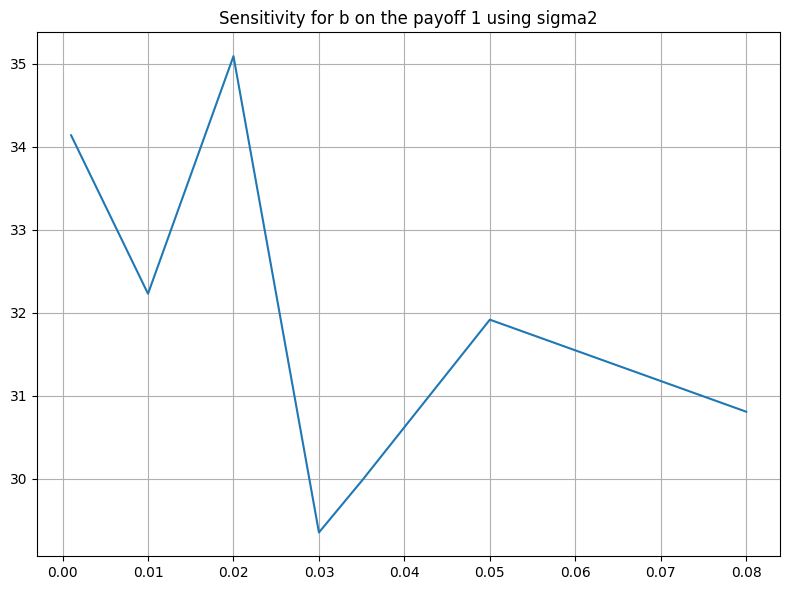

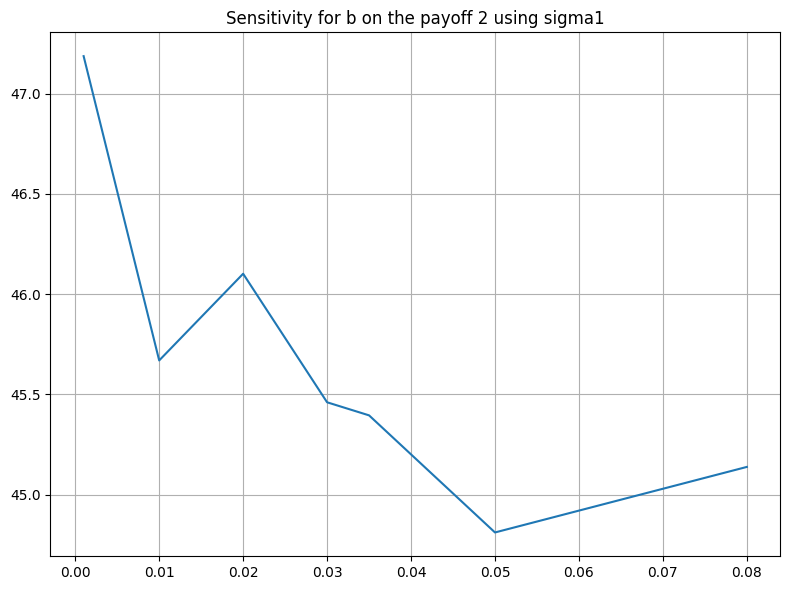

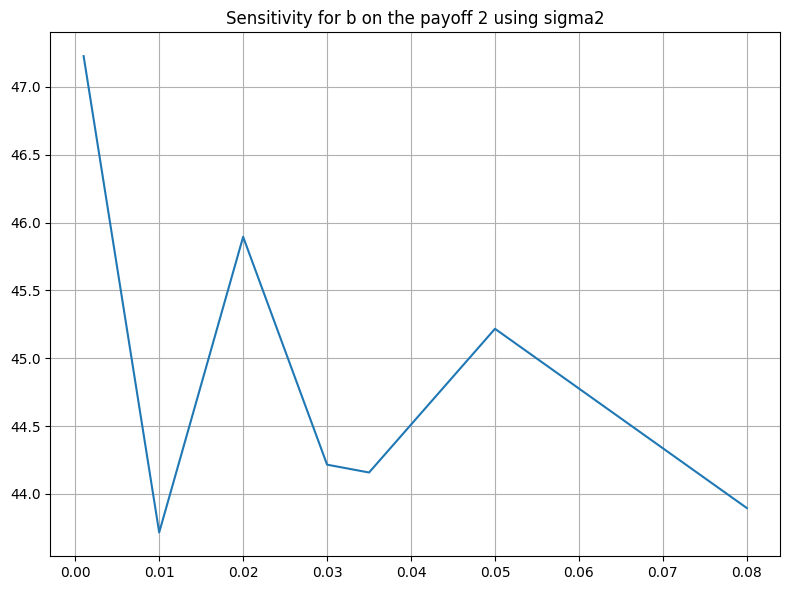

In [22]:
b_list = [0.001, 0.01, 0.02, 0.03, 0.035, 0.05, 0.08] # Japan- Long-term low rate regime, US / Europe (current era)-Post-2008: lower rates → think 1%–2%. In higher inflation scenarios → up to 3–3.5%
                                                      # Emerging markets - higher inflations and risk premiums

POE1_1_b = [] 
POE1_2_b = [] 
POE2_1_b = [] 
POE2_2_b = []

for b  in b_list:
    result = run_trajectory(T=4, N=1000, n=1000, r0= 0.03, a = 0.1, b = b,
                    gamma = 0.2, rho = 0.6, S_tilda0 = 50, k = 0.3,
                    alpha = 1.2, beta = 1.5, K1=30, K2=70)  
    POE1_1_b.append(result[0])
    POE1_2_b.append(result[1])
    POE2_1_b.append(result[2])
    POE2_2_b.append(result[3])
      
    

plot_traject(b_list, POE1_1_b, "Sensitivity for b on the payoff 1 using sigma1")
plot_traject(b_list, POE1_2_b, "Sensitivity for b on the payoff 1 using sigma2")
plot_traject(b_list, POE2_1_b, "Sensitivity for b on the payoff 2 using sigma1")
plot_traject(b_list, POE2_2_b, "Sensitivity for b on the payoff 2 using sigma2")

### 3. Sensitivity for 𝛾
γ: Volatility Coefficient. Controls the magnitude of randomness in the process. Multiplies np.sqrt(rt) so volatility is state-dependent: higher when rates are higher. Reflects uncertainty or instability in the interest rate environment (e.g., during crises)

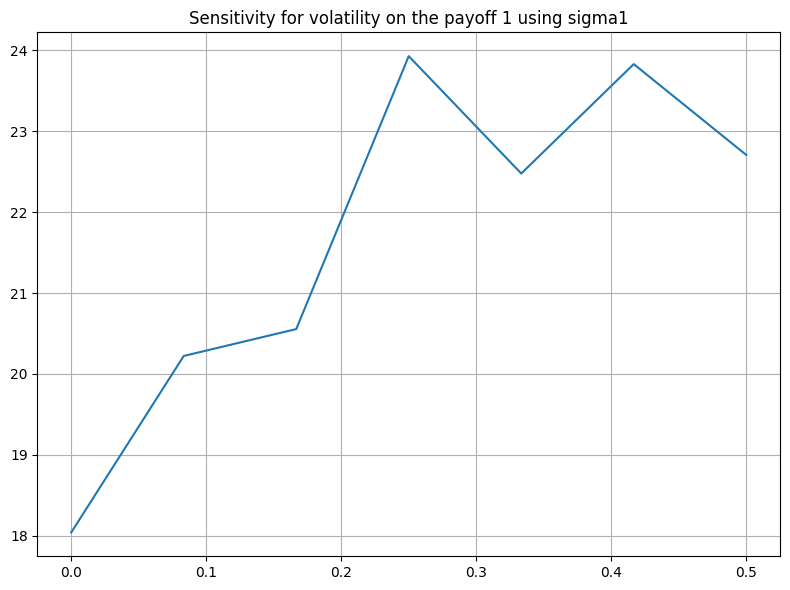

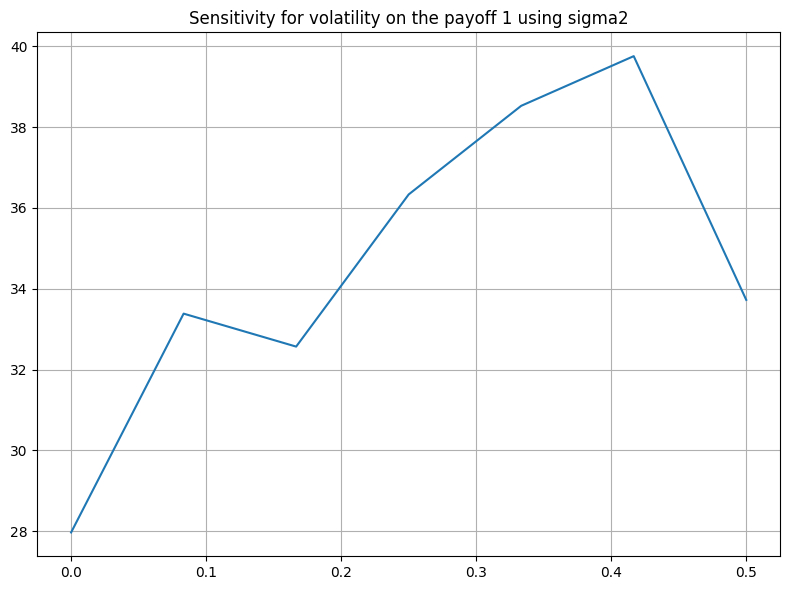

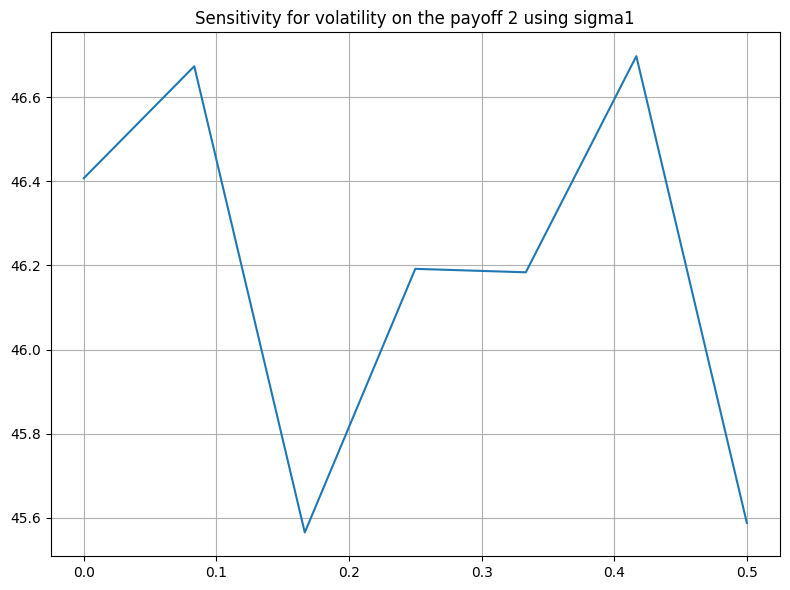

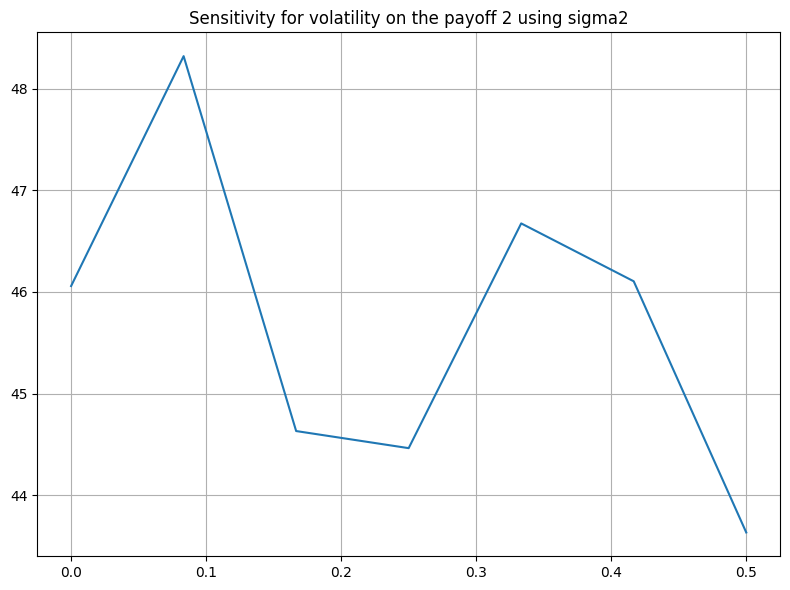

In [ ]:
gamma_values = np.linspace(0, 0.5, 7)

POE1_1_gamma = [] 
POE1_2_gamma = [] 
POE2_1_gamma = [] 
POE2_2_gamma = []

for gamma  in gamma_values:
    result = run_trajectory(T=4, N=1000, n=1000, r0= 0.03, a = 0.1, b = 0.02,
                    gamma = gamma, rho = 0.6, S_tilda0 = 50, k = 0.3,
                    alpha = 1.2, beta = 1.5, K1=30, K2=70)  
    POE1_1_gamma.append(result[0])
    POE1_2_gamma.append(result[1])
    POE2_1_gamma.append(result[2])
    POE2_2_gamma.append(result[3])

plot_traject(gamma_values, POE1_1_gamma, "Sensitivity for volatility on the payoff 1 using sigma1")
plot_traject(gamma_values, POE1_2_gamma, "Sensitivity for volatility on the payoff 1 using sigma2")
plot_traject(gamma_values, POE2_1_gamma, "Sensitivity for volatility on the payoff 2 using sigma1")
plot_traject(gamma_values, POE2_2_gamma, "Sensitivity for volatility on the payoff 2 using sigma2")

### 4. Sensitivity for ρ∈(-1,1)
ρ - Correlation Between Brownian Motion driving the risky Asset price and Interest Rate. Controls the interaction between risk factors. 


Positive 𝜌: when interest rates rise, risky asset tends to go up too (e.g. growth optimism).
Negative 𝜌: rising rates hurt equity (typical in tightening cycles).

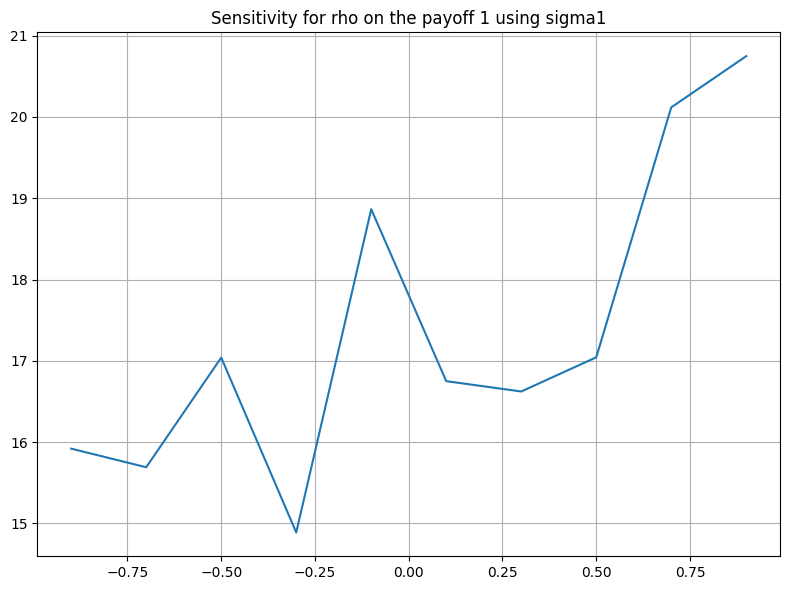

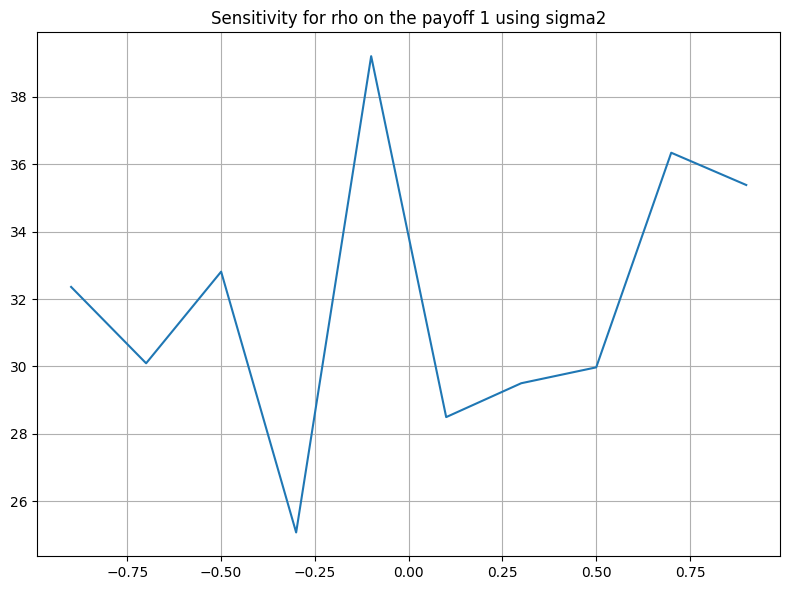

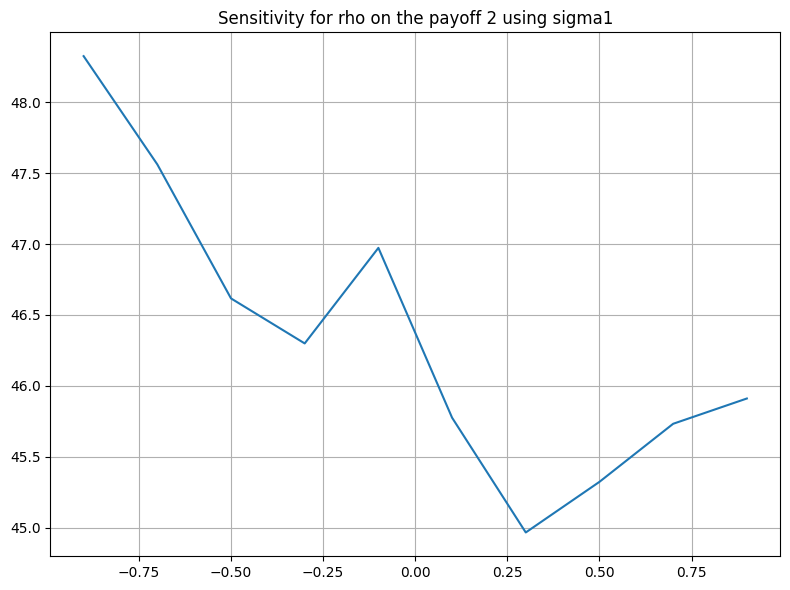

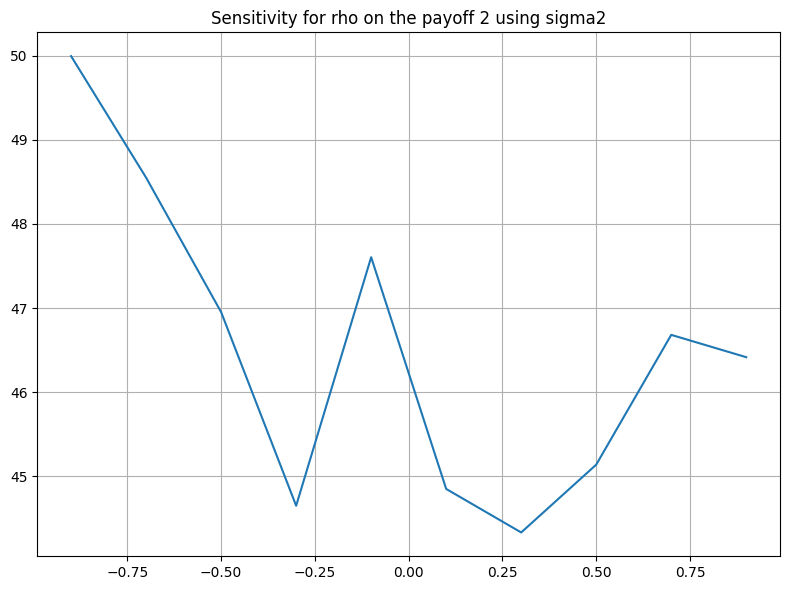

In [23]:
rho_list = np.linspace(-0.9, 0.9, 10)
T=4
N=1000
n=1000

r0= 0.03
a = 0.1
b =  0.02
gamma = 0.2
S_tilda0 = 50
k = 0.3
alpha = 1.2
beta = 1.5

POE1_1_rho = [] 
POE1_2_rho = [] 
POE2_1_rho = [] 
POE2_2_rho = []

for rho  in rho_list:
    result = run_trajectory(T=4, N=1000, n=1000, r0= 0.03, a = 0.1, b = 0.02,
                    gamma = 0.2, rho = rho, S_tilda0 = 50, k = 0.3,
                    alpha = 1.2, beta = 1.5, K1=30, K2=70)  
    POE1_1_rho.append(result[0])
    POE1_2_rho.append(result[1])
    POE2_1_rho.append(result[2])
    POE2_2_rho.append(result[3])

plot_traject(rho_list, POE1_1_rho, "Sensitivity for rho on the payoff 1 using sigma1")
plot_traject(rho_list, POE1_2_rho, "Sensitivity for rho on the payoff 1 using sigma2")
plot_traject(rho_list, POE2_1_rho, "Sensitivity for rho on the payoff 2 using sigma1")
plot_traject(rho_list, POE2_2_rho, "Sensitivity for rho on the payoff 2 using sigma2")

### 5. Sensitivity for k∈(0,1)

k-Scaling of Volatility, is the base level of volatility (scaling factor). Controls the magnitude of the local volatility.

Low 𝑘 low volatility environment (e.g., post-crisis QE).

High 𝑘 turbulent environment, volatile markets.


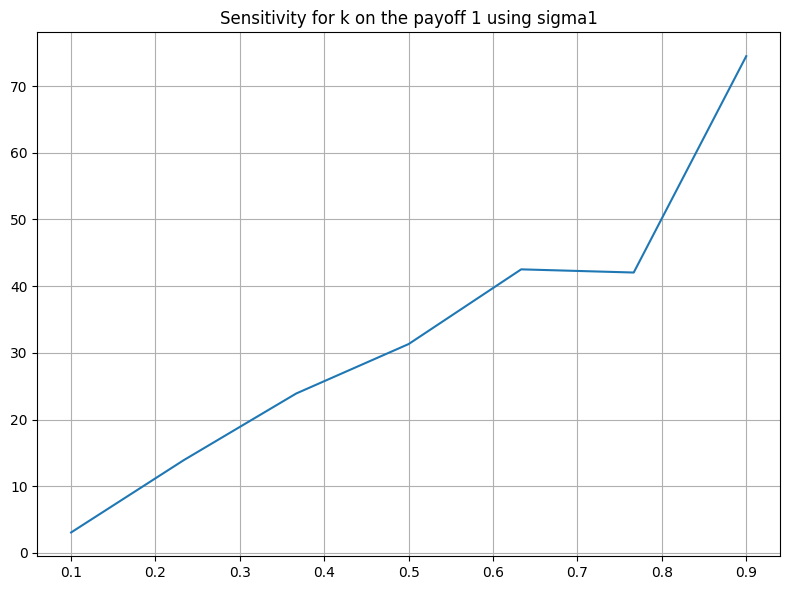

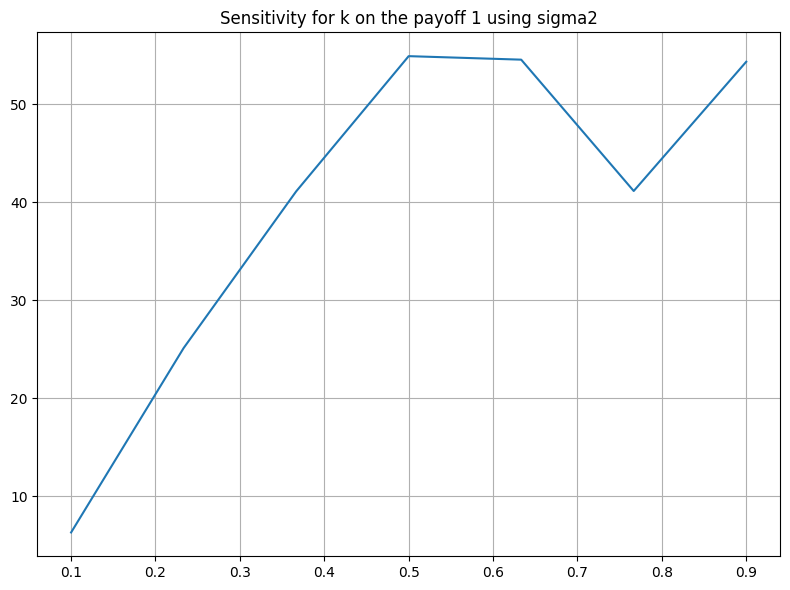

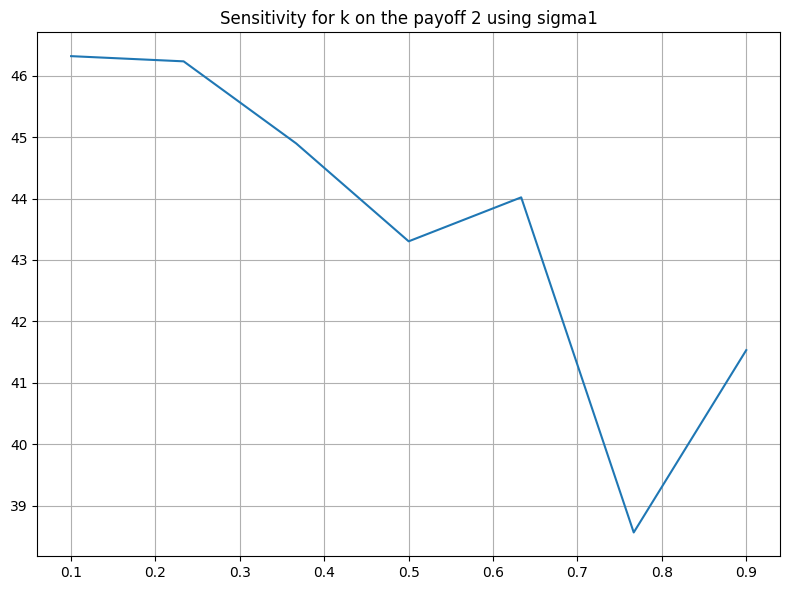

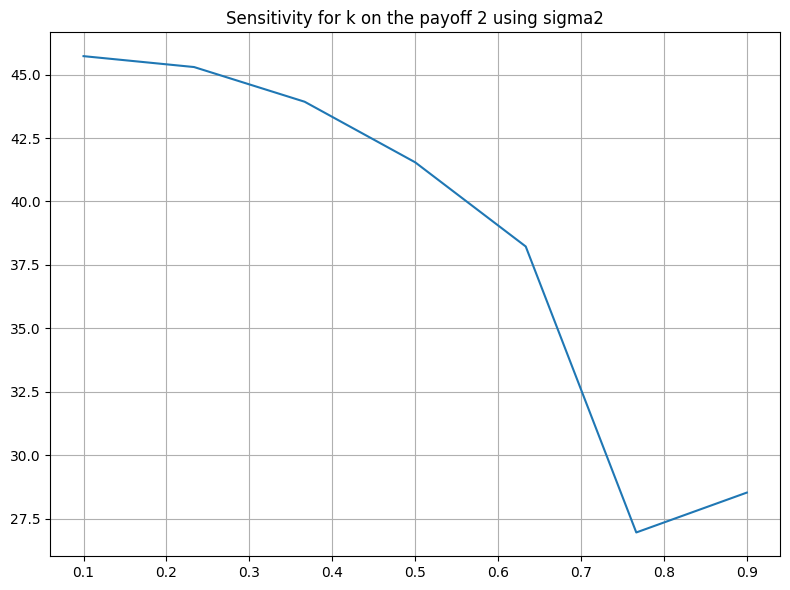

In [24]:
k_list = np.linspace(0.1, 0.9, 7)

POE1_1_k = [] 
POE1_2_k = [] 
POE2_1_k = [] 
POE2_2_k = []

for k  in k_list:
    result = run_trajectory(T=4, N=1000, n=1000, r0= 0.03, a = 0.1, b = 0.02,
                    gamma = 0.2, rho = 0.6, S_tilda0 = 50, k = k,
                    alpha = 1.2, beta = 1.5, K1=30, K2=70)  
    POE1_1_k.append(result[0])
    POE1_2_k.append(result[1])
    POE2_1_k.append(result[2])
    POE2_2_k.append(result[3])

plot_traject(k_list, POE1_1_k, "Sensitivity for k on the payoff 1 using sigma1")
plot_traject(k_list, POE1_2_k, "Sensitivity for k on the payoff 1 using sigma2")
plot_traject(k_list, POE2_1_k, "Sensitivity for k on the payoff 2 using sigma1")
plot_traject(k_list, POE2_2_k, "Sensitivity for k on the payoff 2 using sigma2")

### 6. Sensitivity for α>0 

α — Time Dynamics, it modulates the time-dependence of volatility: In the exponential form, it scales the time slope (𝛼 affects the forward skew-term structure of vol), In the cosine form, it modulates oscillation amplitude (𝛼 gives volatility cycles, useful in modeling seasonality or recurring uncertainty).


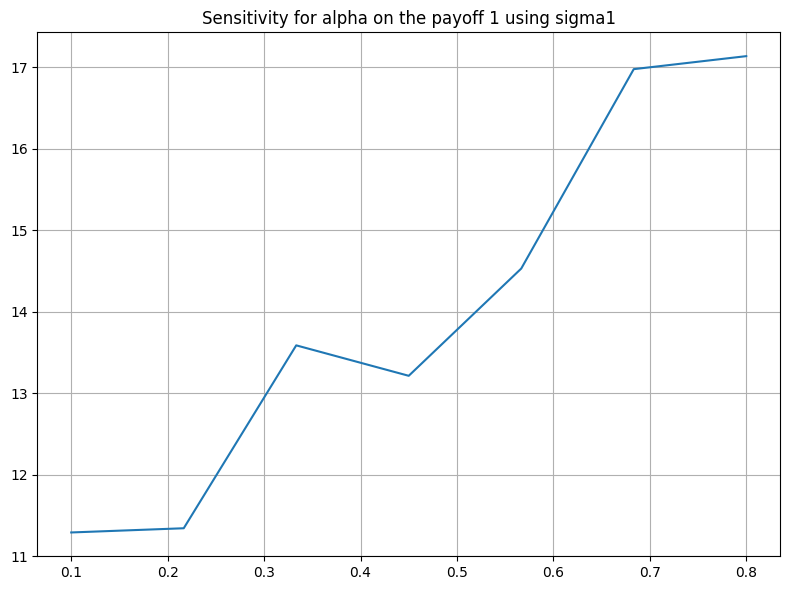

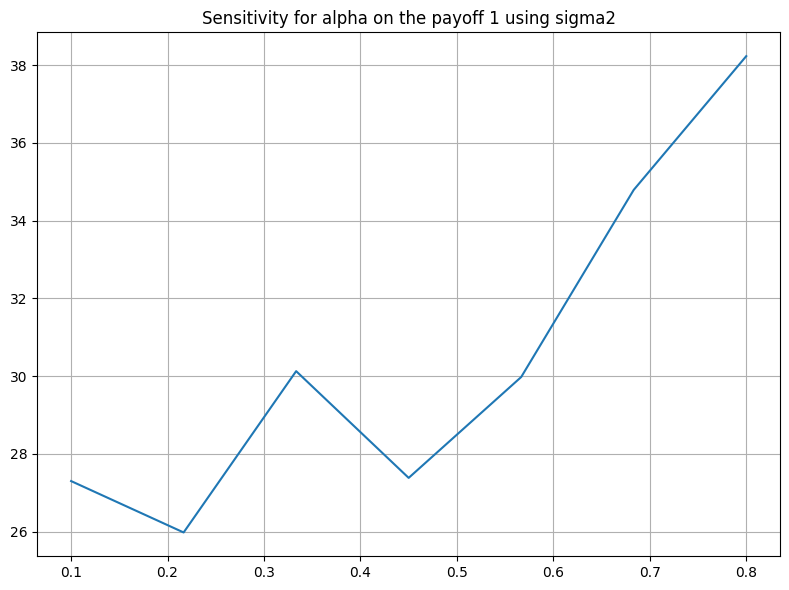

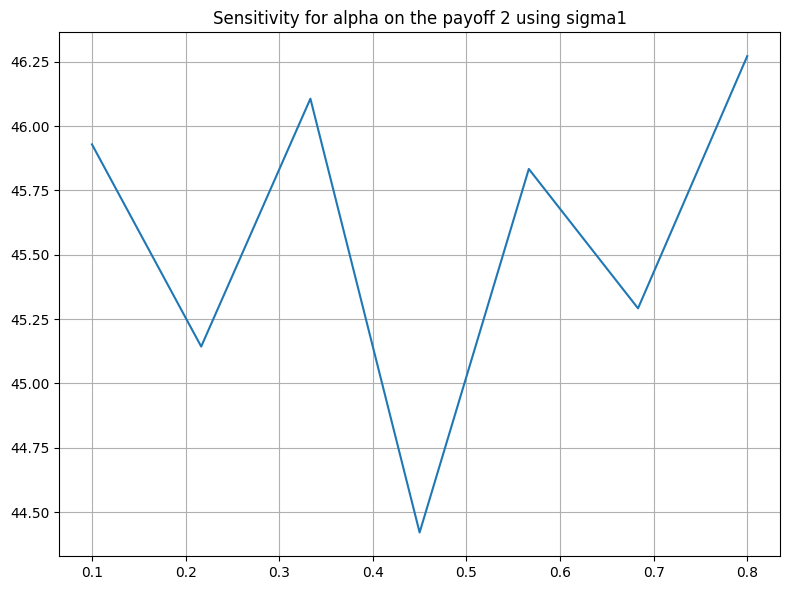

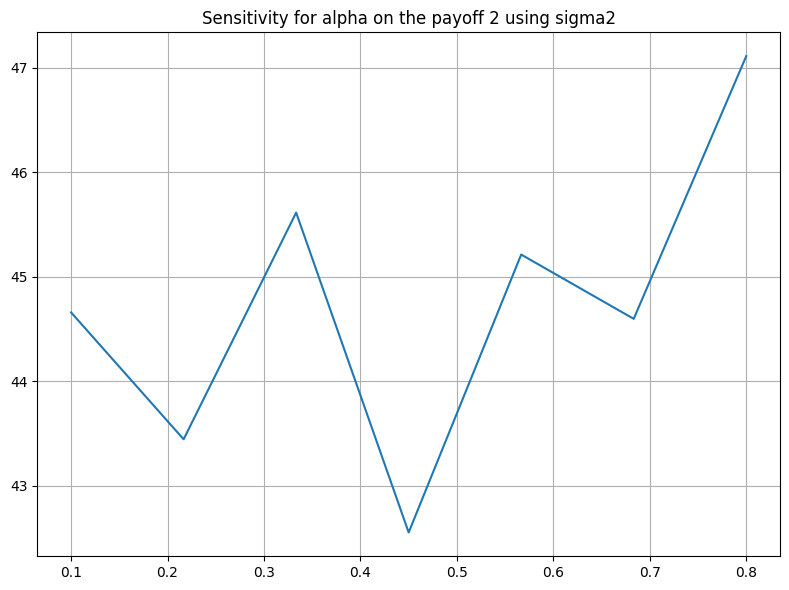

In [25]:
alpha_list = np.linspace(0.1, 0.8, 7)

POE1_1_alpha = [] 
POE1_2_alpha = [] 
POE2_1_alpha = [] 
POE2_2_alpha = []

for alpha  in alpha_list:
    result = run_trajectory(T=4, N=1000, n=1000, r0= 0.03, a = 0.1, b = 0.02,
                    gamma = 0.2, rho = 0.6, S_tilda0 = 50, k = 0.3,
                    alpha = alpha, beta = 1.5, K1=30, K2=70)  
    POE1_1_alpha.append(result[0])
    POE1_2_alpha.append(result[1])
    POE2_1_alpha.append(result[2])
    POE2_2_alpha.append(result[3])

      

plot_traject(alpha_list, POE1_1_alpha, "Sensitivity for alpha on the payoff 1 using sigma1")
plot_traject(alpha_list, POE1_2_alpha, "Sensitivity for alpha on the payoff 1 using sigma2")
plot_traject(alpha_list, POE2_1_alpha, "Sensitivity for alpha on the payoff 2 using sigma1")
plot_traject(alpha_list, POE2_2_alpha, "Sensitivity for alpha on the payoff 2 using sigma2")

### 7. Sensitivity for 𝛽>0
β- Spot-level Dependence, it modulates how volatility depends on the underlying asset level. Models volatility smile/skew.

Higher β: volatility increases at low asset levels (common in equity markets: leverage effect).

In exponential form makes vol explode when x→−∞ (low prices). In cosine form milder, more symmetric skew.

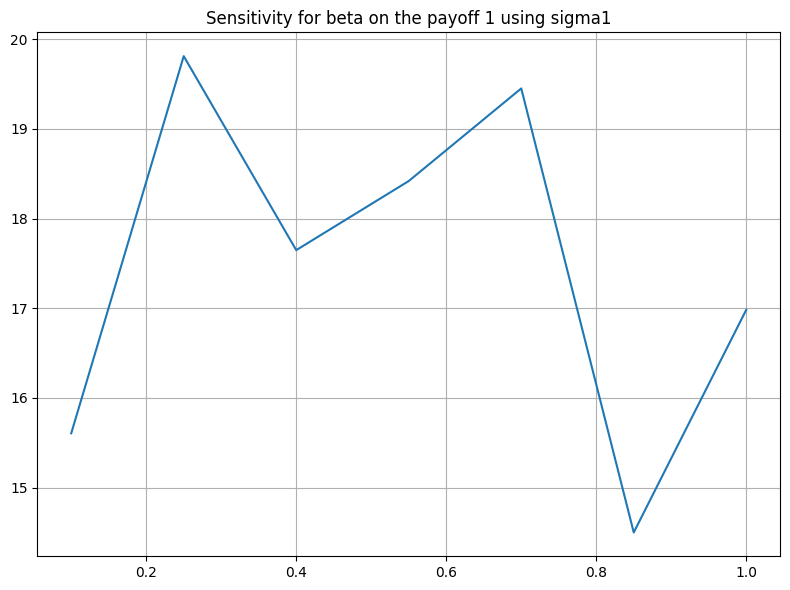

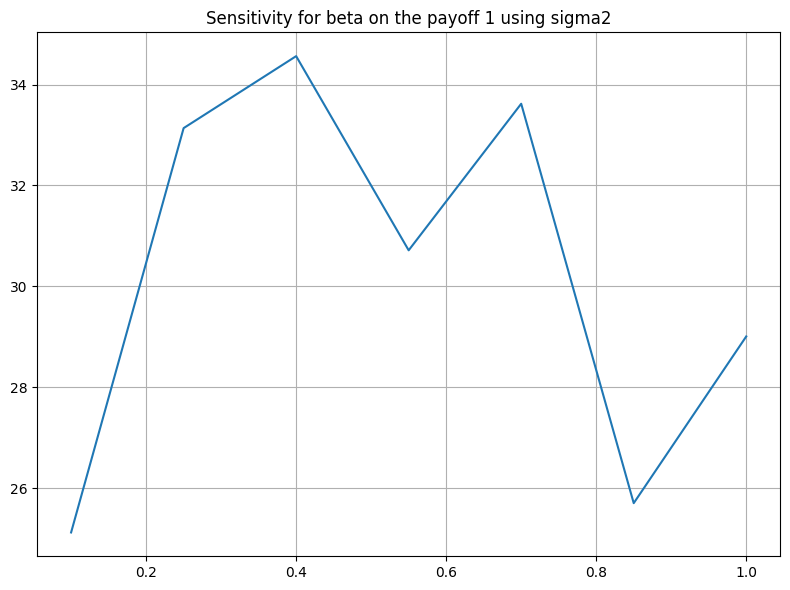

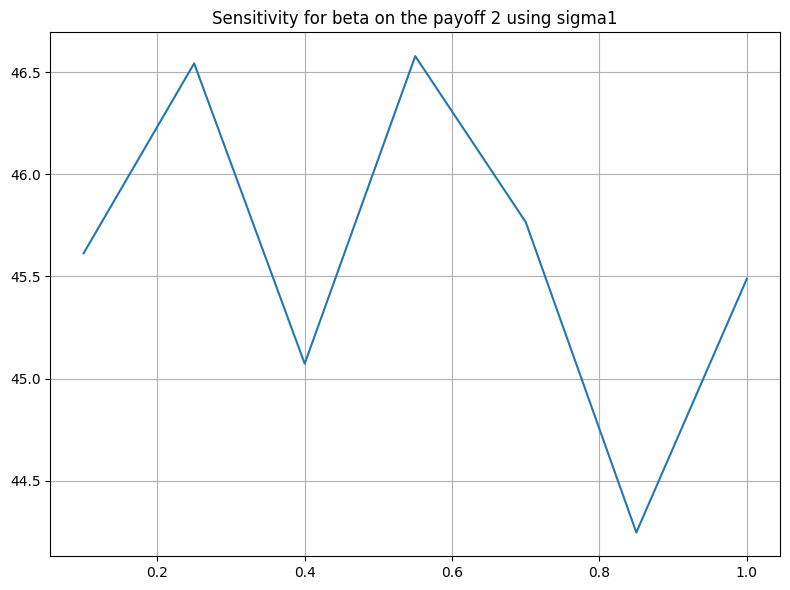

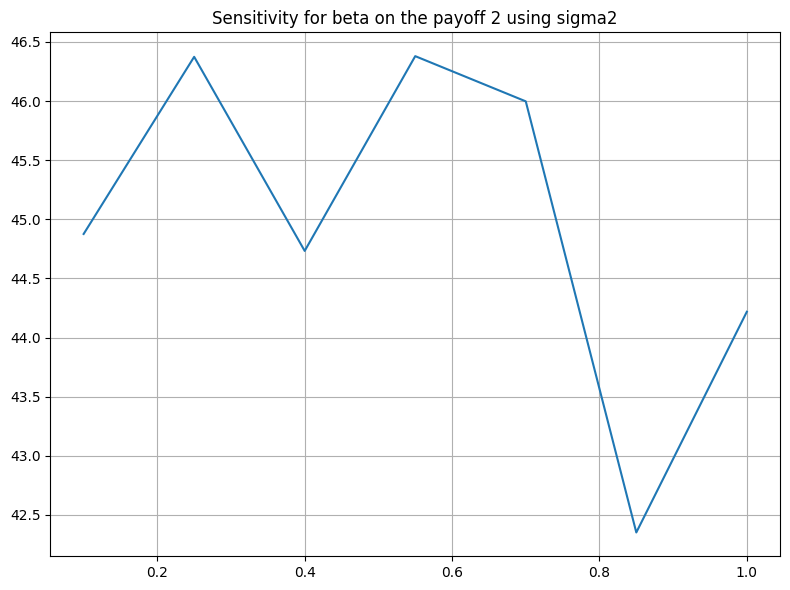

In [26]:
beta_list = np.linspace(0.1, 1, 7)

POE1_1_beta = [] 
POE1_2_beta = [] 
POE2_1_beta = [] 
POE2_2_beta = []

for beta in beta_list:
    result = run_trajectory(T=4, N=1000, n=1000, r0= 0.03, a = 0.1, b = 0.02,
                    gamma = 0.2, rho = 0.6, S_tilda0 = 50, k = 0.3,
                    alpha = 1.2, beta = beta, K1=30, K2=70)  
    POE1_1_beta.append(result[0])
    POE1_2_beta.append(result[1])
    POE2_1_beta.append(result[2])
    POE2_2_beta.append(result[3])

   

plot_traject(beta_list, POE1_1_beta, "Sensitivity for beta on the payoff 1 using sigma1")
plot_traject(beta_list, POE1_2_beta, "Sensitivity for beta on the payoff 1 using sigma2")
plot_traject(beta_list, POE2_1_beta, "Sensitivity for beta on the payoff 2 using sigma1")
plot_traject(beta_list, POE2_2_beta, "Sensitivity for beta on the payoff 2 using sigma2")

### 8. Sensitivity for r0
r0 is the starting point of the short-term interest rate

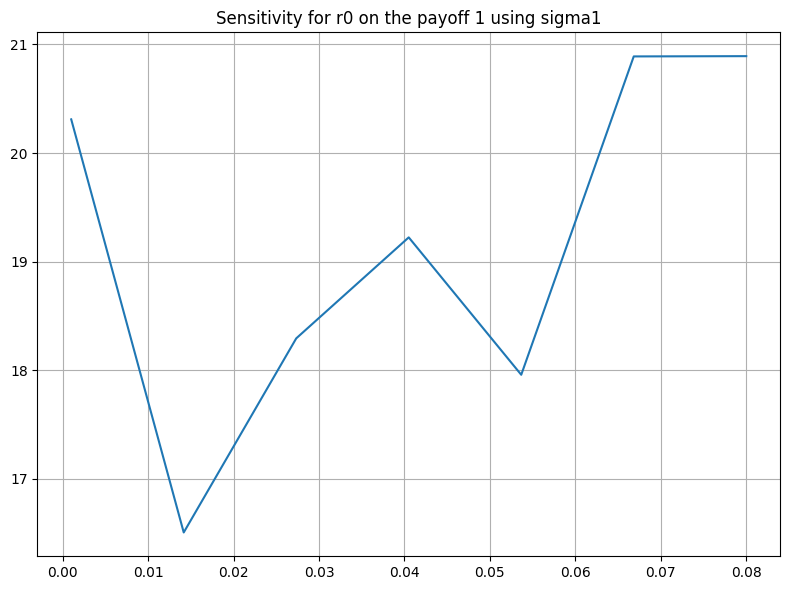

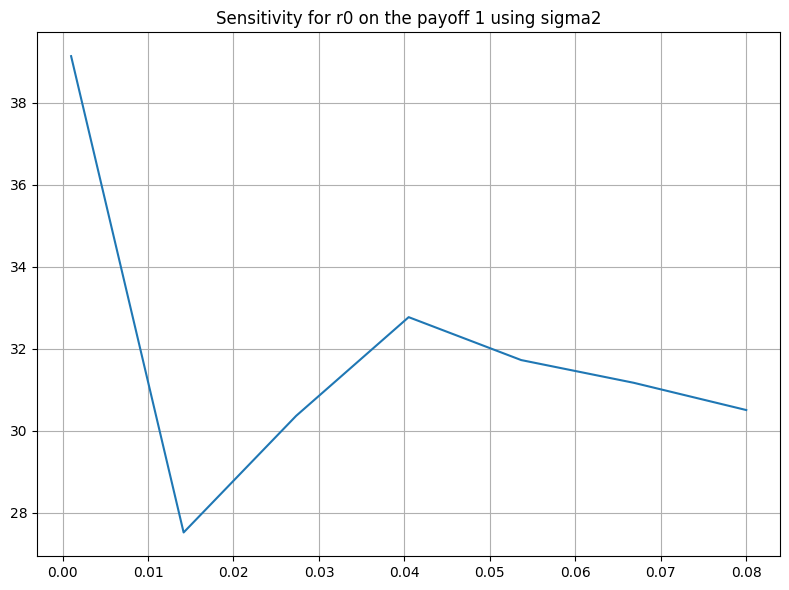

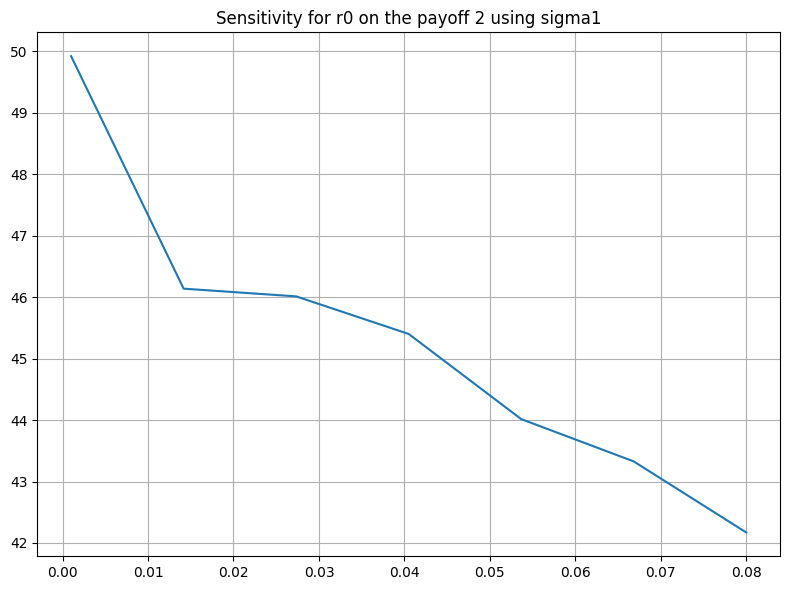

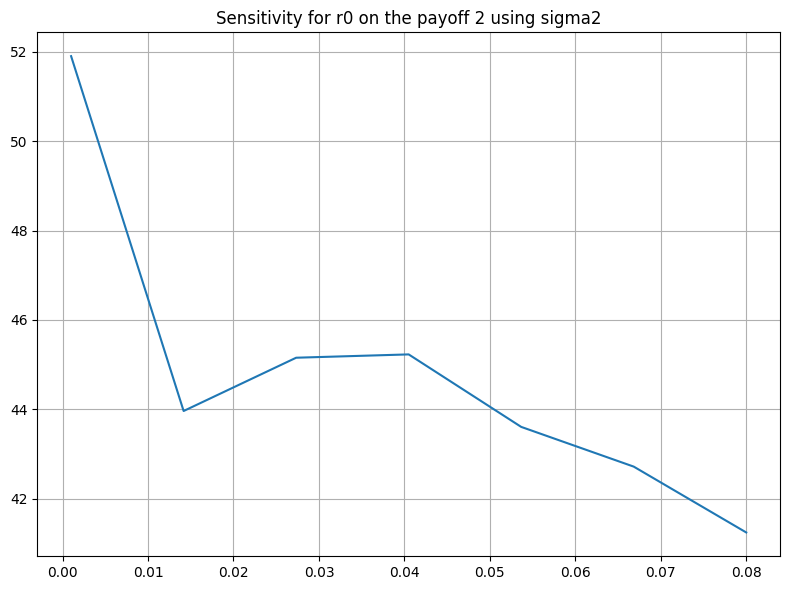

In [27]:
r0_list = np.linspace(0.001, 0.08, 7)

POE1_1_r0 = [] 
POE1_2_r0  = [] 
POE2_1_r0  = [] 
POE2_2_r0  = []

for r0 in r0_list:
    result = run_trajectory(T=4, N=1000, n=1000, r0= r0, a = 0.1, b = 0.02,
                    gamma = 0.2, rho = 0.6, S_tilda0 = 50, k = 0.3,
                    alpha = 1.2, beta = 1.5, K1=30, K2=70)  
    POE1_1_r0.append(result[0])
    POE1_2_r0.append(result[1])
    POE2_1_r0.append(result[2])
    POE2_2_r0.append(result[3])
     

plot_traject(r0_list, POE1_1_r0, "Sensitivity for r0 on the payoff 1 using sigma1")
plot_traject(r0_list, POE1_2_r0, "Sensitivity for r0 on the payoff 1 using sigma2")
plot_traject(r0_list, POE2_1_r0, "Sensitivity for r0 on the payoff 2 using sigma1")
plot_traject(r0_list, POE2_2_r0, "Sensitivity for r0 on the payoff 2 using sigma2")